In [1]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('check')

check


# Data Preprocessing



**store the data into data frames**

In [2]:
# Generate data paths with labels
train_data_dir = 'D:/Project/Brain tumor/brain-tumor-mri-dataset/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [3]:
# Generate data paths with labels
test_data_dir = 'D:/Project/Brain tumor/brain-tumor-mri-dataset/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
ts_df = pd.concat([Fseries, Lseries], axis= 1)

In [4]:
train_df

,filepaths,labels
0,D:/Project/Brain tumor/brain-tumor-mri-dataset...,glioma
1,D:/Project/Brain tumor/brain-tumor-mri-dataset...,glioma
2,D:/Project/Brain tumor/brain-tumor-mri-dataset...,glioma
3,D:/Project/Brain tumor/brain-tumor-mri-dataset...,glioma
4,D:/Project/Brain tumor/brain-tumor-mri-dataset...,glioma
...,...,...
5707,D:/Project/Brain tumor/brain-tumor-mri-dataset...,pituitary
5708,D:/Project/Brain tumor/brain-tumor-mri-dataset...,pituitary
5709,D:/Project/Brain tumor/brain-tumor-mri-dataset...,pituitary
5710,D:/Project/Brain tumor/brain-tumor-mri-dataset...,pituitary


In [5]:
ts_df

,filepaths,labels
0,D:/Project/Brain tumor/brain-tumor-mri-dataset...,glioma
1,D:/Project/Brain tumor/brain-tumor-mri-dataset...,glioma
2,D:/Project/Brain tumor/brain-tumor-mri-dataset...,glioma
3,D:/Project/Brain tumor/brain-tumor-mri-dataset...,glioma
4,D:/Project/Brain tumor/brain-tumor-mri-dataset...,glioma
...,...,...
1306,D:/Project/Brain tumor/brain-tumor-mri-dataset...,pituitary
1307,D:/Project/Brain tumor/brain-tumor-mri-dataset...,pituitary
1308,D:/Project/Brain tumor/brain-tumor-mri-dataset...,pituitary
1309,D:/Project/Brain tumor/brain-tumor-mri-dataset...,pituitary


Split dataframe into train, valid, and test (we see that data splitted into train and test)


In [6]:
valid_df, test_df = train_test_split(ts_df,  train_size= 0.5, shuffle= True, random_state= 123)

Create image data generator


In [7]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


Show sample from train data


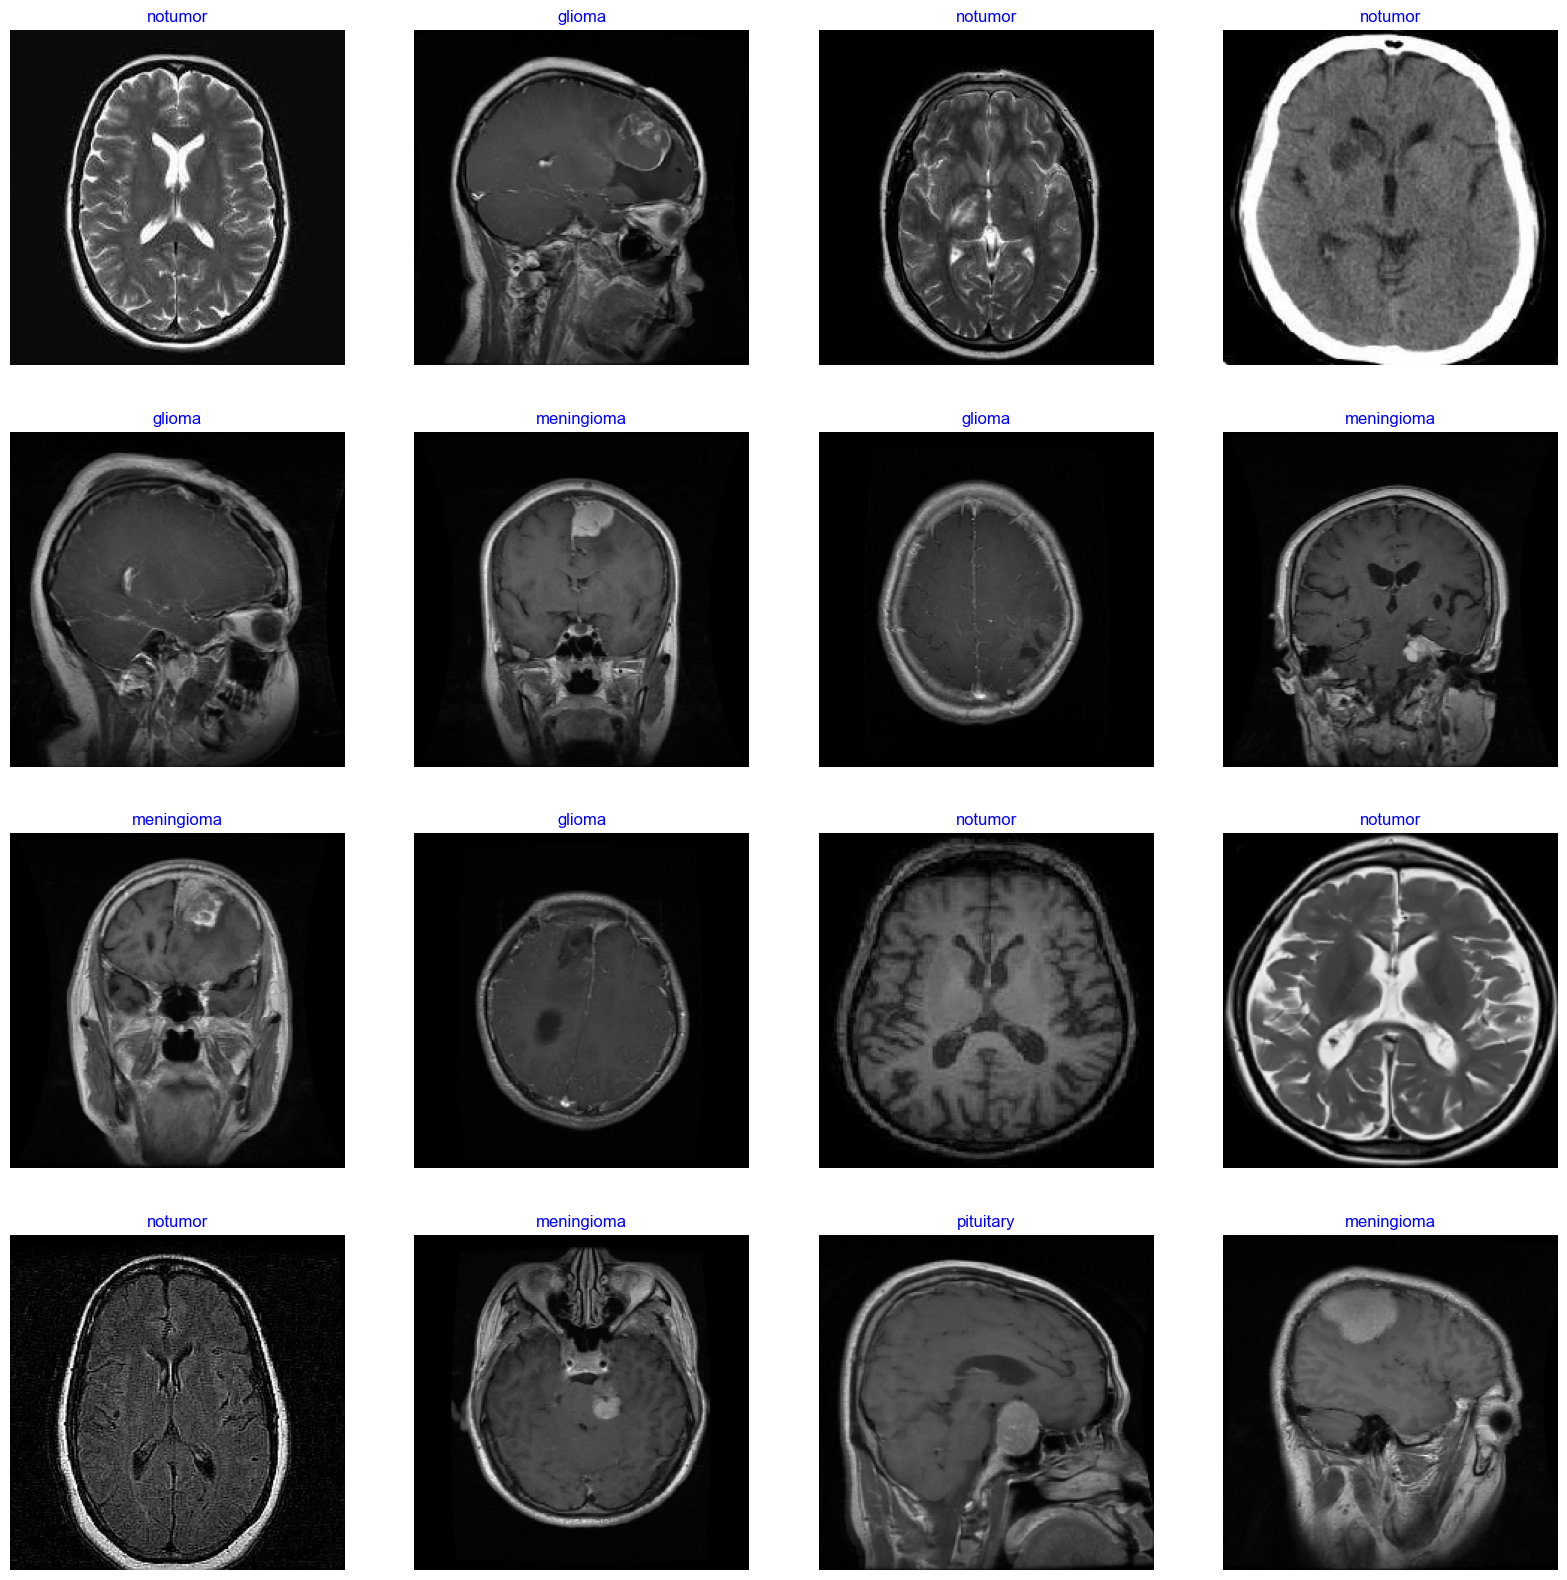

In [8]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

# now lets belt our Model Structure¶


In [9]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 4
model =Sequential ([
    Conv2D(filters=64,kernel_size=(3,3),activation="relu",input_shape=img_shape),
    Conv2D(filters=64,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=128,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    
    
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=256,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    Conv2D(filters=512,kernel_size=(3,3),activation="relu"),
    MaxPooling2D((2,2)),
    
    Flatten(),
    Dense(256,activation="relu"),
    
    Dense(128,activation="relu"),
    Dense(4,activation="softmax")
])
model.compile (Adamax(learning_rate=0.001),loss='categorical_crossentropy', metrics=["accuracy"])
model.summary()
    

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)      │      1,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 220, 220, 64)      │     36,928 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 64)      │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 108, 108, 128)     │     73,856 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 106, 106, 128)     │    147,584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 128)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 51, 51, 256)       │    295,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 49, 49, 256)       │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_6 (Conv2D)               │ (None, 47, 47, 256)       │    590,080 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 256)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_7 (Conv2D)               │ (None, 21, 21, 512)       │  1,180,160 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_8 (Conv2D)               │ (None, 19, 19, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_9 (Conv2D)               │ (None, 17, 17, 512)       │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_12 (Conv2D)              │ (None, 2, 2, 512)         │  2,359,808 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 512)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 256)               │    131,328 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 128)               │     32,896 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 4)                 │        516 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 14,879,428 (56.76 MB)

 Trainable params: 14,879,428 (56.76 MB)

 Non-trainable params: 0 (0.00 B)

# lets train data in our model

In [10]:
epochs = 10   # number of all epochs in training

history = model.fit(train_gen , epochs= epochs , verbose= 1, validation_data= valid_gen, shuffle= False)

Epoch 1/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 3109s 9s/step - accuracy: 0.3779 - loss: 6.3802 - val_accuracy: 0.5282 - val_loss: 1.0139
Epoch 2/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 4103s 12s/step - accuracy: 0.7099 - loss: 0.7047 - val_accuracy: 0.7634 - val_loss: 0.6158
Epoch 3/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 2305s 6s/step - accuracy: 0.8452 - loss: 0.4452 - val_accuracy: 0.8168 - val_loss: 0.4506
Epoch 4/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1620s 5s/step - accuracy: 0.8720 - loss: 0.3408 - val_accuracy: 0.8214 - val_loss: 0.4274
Epoch 5/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 2674s 7s/step - accuracy: 0.8979 - loss: 0.2752 - val_accuracy: 0.8565 - val_loss: 0.3727
Epoch 6/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 1880s 5s/step - accuracy: 0.9182 - loss: 0.2182 - val_accuracy: 0.8947 - val_loss: 0.2969
Epoch 7/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 4618s 13s/step - accuracy: 0.9395 - loss: 0.1827 - val_accuracy: 0.8901 - val_loss: 0.2793
Epoch 8/10
357/357 ━━━━━━━━━━━━━━━━━━━━ 2321s 6s/step - accuracy: 0.9449 - loss: 0.1590 

# model performance

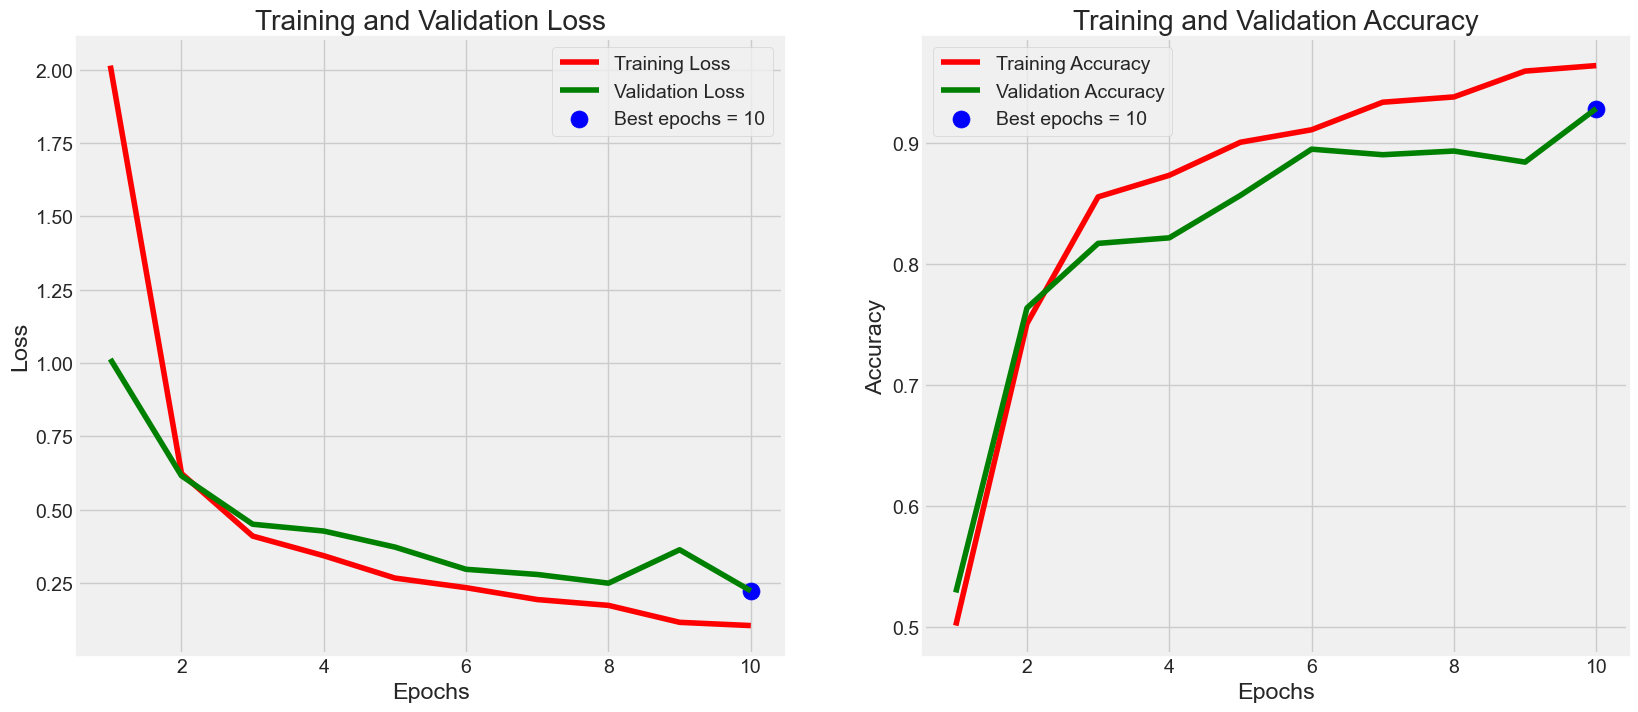

In [11]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();


# model evaluation

In [12]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9648 - loss: 0.1080
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9450 - loss: 0.1577
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9388 - loss: 0.2049
Train Loss:  0.10039804875850677
Train Accuracy:  0.97265625
--------------------
Validation Loss:  0.19456125795841217
Validation Accuracy:  0.9296875
--------------------
Test Loss:  0.21839813888072968
Test Accuracy:  0.921875


# model predection

In [13]:
preds = model.predict(test_gen)

y_pred = np.argmax(preds , axis = 1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step


In [14]:
preds


array([[9.2977360e-02, 9.0677226e-01, 2.4404359e-04, 6.3616963e-06],
       [3.1584808e-05, 1.4285085e-03, 9.9822837e-01, 3.1161439e-04],
       [6.3854300e-06, 3.7837999e-05, 2.5515839e-05, 9.9993026e-01],
       ...,
       [7.0312445e-09, 4.1335406e-06, 2.7076754e-07, 9.9999559e-01],
       [7.4003494e-01, 2.5412831e-01, 3.8678057e-03, 1.9690022e-03],
       [3.7578196e-04, 1.0095272e-02, 9.8952079e-01, 8.1499638e-06]],
      dtype=float32)

# confusion matrix

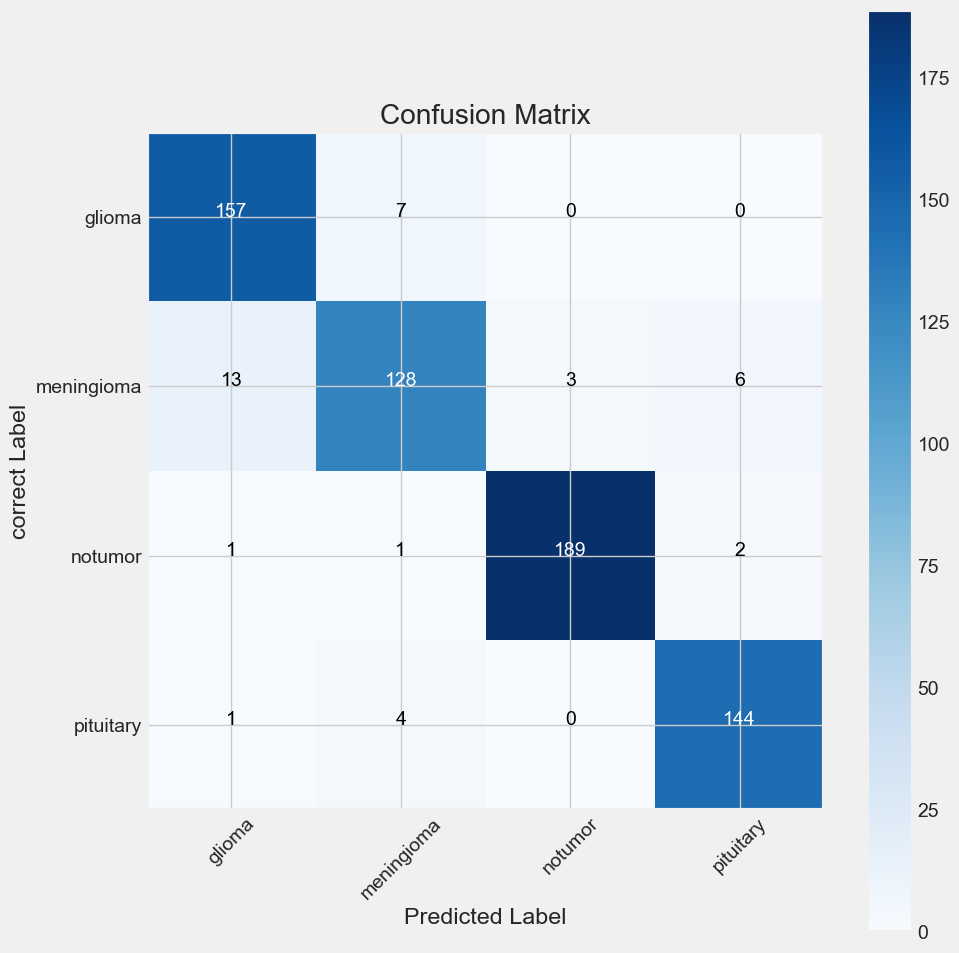

In [15]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('correct Label')
plt.xlabel('Predicted Label')

plt.show()

# classification report

In [16]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.91      0.96      0.93       164
  meningioma       0.91      0.85      0.88       150
     notumor       0.98      0.98      0.98       193
   pituitary       0.95      0.97      0.96       149

    accuracy                           0.94       656
   macro avg       0.94      0.94      0.94       656
weighted avg       0.94      0.94      0.94       656

